# DACON KAERI: Collision detection using vibration data

## Team name: IME

## Submission date: 17/07/2020

#1: Library and data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import platform
import json
import gc
import os
import random
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import collections
import resource
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchsummary import summary

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define here the input/output paths for loading the data and saving models/predictions


In [2]:
# define path to read dataset
path = '/content/drive/My Drive/ML Projects/DACON/Kaeri/data/'

# define path to save predictions and submission
out_path = '/content/drive/My Drive/ML Projects/DACON/Kaeri/'   #'./'

# define path to save models (modify if needed)
MODEL_PATH = '/content/drive/My Drive/ML Projects/DACON/Kaeri/models/'      

### Helpers

In [3]:
# Read dataset
# COLAB = True

# if COLAB: path = '/content/drive/My Drive/ML Projects/DACON/Colision/data/'
# else: path = './ML Projects/DACON/data/'

def read_data(path=path):
    train_df = pd.read_csv(path+'train_features.csv',)     
    train_target = pd.read_csv(path+'train_target.csv', )  
    test_df = pd.read_csv(path+'test_features.csv', )                
    subm = pd.read_csv(path+"sample_submission.csv")
    print('Shape of train:', train_df.shape)
    print('Shape of solution:', test_df.shape)
    print('Shape of submision:', subm.shape)
    return train_df, train_target, test_df, subm

In [4]:
# Keras helper functions

class LRFinder(Callback):
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset.  
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


class WarmUpCosineDecayScheduler(Callback):
    """
        Cosine decay with warmup learning rate scheduler
    """
    def __init__(self,
                 learning_rate_base,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_epoch=0,
                 hold_base_rate_steps=0,
                 learning_rate_final=None,
                 stop_epoch=None,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
        Arguments:
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            global_step_init {int} -- initial global step, e.g. from previous checkpoint.
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_epoch = warmup_epoch
        self.hold_base_rate_steps = hold_base_rate_steps
        self.learning_rates = []
        self.verbose = verbose
        self.stop_epoch = stop_epoch
        self.learning_rate_final = learning_rate_final
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        total_steps = int(
            self.params['epochs'] * self.params['samples'] / self.params['batch_size'])
        warmup_steps = int(
            self.warmup_epoch * self.params['samples']  / self.params['batch_size'])
        lr = self.cosine_decay_with_warmup(
            global_step=self.global_step,
            learning_rate_base=self.learning_rate_base,
            total_steps=total_steps,
            warmup_learning_rate=self.warmup_learning_rate,
            warmup_steps=warmup_steps,
            hold_base_rate_steps=self.hold_base_rate_steps)
        if self.stop_epoch is not None and self.stop_epoch > 0 and self.epoch >= self.stop_epoch:
            if self.learning_rate_final is not None:
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
            else:
                self.learning_rate_final = lr
                K.set_value(self.model.optimizer.lr, self.learning_rate_final)
        else:
            K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

    def cosine_decay_with_warmup(self, global_step,
                                 learning_rate_base,
                                 total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0):
        """Cosine decay schedule with warm up period.
        Cosine annealing learning rate as described in
            Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
            ICLR 2017. https://arxiv.org/abs/1608.03983
        In this schedule, the learning rate grows linearly from warmup_learning_rate
        to learning_rate_base for warmup_steps, then transitions to a cosine decay
        schedule.
        Arguments:
            global_step {int} -- global step.
            learning_rate_base {float} -- base learning rate.
            total_steps {int} -- total number of training steps.
        Keyword Arguments:
            warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
            warmup_steps {int} -- number of warmup steps. (default: {0})
            hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                        before decaying. (default: {0})
        Returns:
            a float representing learning rate.
        Raises:
            ValueError: if warmup_learning_rate is larger than learning_rate_base,
            or if warmup_steps is larger than total_steps.
        """
        if total_steps < warmup_steps:
            raise ValueError('total_steps must be larger or equal to '
                             'warmup_steps.')
        learning_rate = 0.5 * learning_rate_base * (
            1 + np.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) /
                float(total_steps - warmup_steps - hold_base_rate_steps)
                )
            )
        if hold_base_rate_steps > 0:
            learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                     learning_rate, learning_rate_base)
        if warmup_steps > 0:
            if learning_rate_base < warmup_learning_rate:
                raise ValueError('learning_rate_base must be larger or equal to '
                                 'warmup_learning_rate.')
            slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
            warmup_rate = slope * global_step + warmup_learning_rate
            learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                     learning_rate)
        return np.where(global_step > total_steps, 0.0, learning_rate)


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


def step_decay_schedule(initial_lr=1e-5, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)


def r2_keras(y_true, y_pred):
    K = tf.keras.backend
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def kaeri_metric(y_true,  y_pred):

    '''
        y_true: dataframe with true values ​​of X,Y,M,V
        y_pred: dataframe with pred values ​​of X,Y,M,V

        return: KAERI metric
    '''
    t1, p1 = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    E1 = np.mean(np.sum(np.square(t1 - p1), axis=1) / 2e+04)
      
    t2, p2 = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    E2 = np.mean(np.sum(np.square((t2 - p2) / (t2 + 1e-06)), axis=1))
    return 0.5*E1 + 0.5*E2
   


In [5]:
# Data preprocessing helpers

def calc_ewm(s, windows=[10, 50]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)       
    return ewm


def preprocess_data(df, cols=["S1","S2",'S3','S4']):

    sensor_cols = cols # ['S1','S2','S3','S4']
    df2 = pd.DataFrame(index=df.groupby(['id'])['id'].apply(pd.Series).unique())
    df2['Time'] = df['Time']

    for col in sensor_cols:
        df2[col+'_mean'] = df.groupby(['id'])[col].apply(lambda x: np.mean(x))
        df2[col+'_max'] = df.groupby(['id'])[col].apply(lambda x: np.max(x))
        df2[col+'_min'] = df.groupby(['id'])[col].apply(lambda x: np.min(x))
        df2[col+'_std'] = df.groupby(['id'])[col].apply(lambda x: np.std(x))
        df2[col+'_median'] = df.groupby(['id'])[col].apply(lambda x: np.median(x))

        df2[col+'_p10'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 10))
        df2[col+'_p25'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 25))
        df2[col+'_p75'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 75))
        df2[col+'_p90'] = df.groupby(['id'])[col].apply(lambda x: np.percentile(x, 90))
        df2[col+'_skew'] = df.groupby(['id'])[col].apply(lambda x: pd.Series(x).skew())

        min_max = (df2[col+'_mean'] - df2[col+'_min']) / (df2[col+'_max'] - df2[col+'_min'])
        df2[col+'_norm'] = min_max * (np.floor(df2[col+'_max']) - np.ceil(df2[col+'_min']))
        df2[col+'_mean_abs_chg'] = df.groupby(['id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df2[col+'_abs_max'] = df.groupby(['id'])[col].apply(lambda x: np.max(np.abs(x)))
        df2[col+'_abs_min'] = df.groupby(['id'])[col].apply(lambda x: np.min(np.abs(x)))
        df2[col+'_range'] = df2[col+'_max'] - df2[col+'_min']
        df2[col+'_maxtomin'] = df2[col+'_max'] / df2[col+'_min']
        df2[col+'_abs_avg'] = (df2[col+'_abs_min'] + df2[col+'_abs_max']) / 2

        # ewm = calc_ewm(df[col])
        # ewm.columns = [col+'_'+n for n in ewm.columns]
        # df2 = pd.concat([df2, ewm], axis=1)

    return df2


def batching(df,batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['id'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

def lag_with_pct_change(df, shift_sizes, add_pct_change=False, add_pct_change_lag=False):
    
    for col in ['S1', 'S2', 'S3', 'S4']:
        
        for shift_size in shift_sizes:    
            
            df[col+'_shift_pos_'+str(shift_size)] = df[col].shift(shift_size).fillna(0)
            df[col+'_shift_neg_'+str(shift_size)] = df[col].shift(-1*shift_size).fillna(0)

            if add_pct_change:
                df[col+'_pct_change'] = df[col].pct_change()

                if add_pct_change_lag:
                    for shift_size in shift_sizes:    
                        df[col+'_pct_change_shift_pos_'+str(shift_size)] = df[col+'_pct_change'].shift(shift_size).fillna(0)
                        df[col+'_pct_change_shift_neg_'+str(shift_size)] = df[col+'_pct_change'].shift(-1*shift_size).fillna(0)
        
    return df

def make_fft_features(df):
    ffts = []
    for col in ['S1', 'S2', 'S3', 'S4']:
        sig = df[col].values.reshape(int(len(df)/375), 375)
        s1_fft = np.abs(np.fft.fft(sig, axis=1)) 
        ffts.append(s1_fft)

    return np.array(ffts).reshape(int(len(df)/375), 375, -1)


def plot_error(type_id, pred, true):

    print(pred.shape)

    if type_id == 0: _name = 'x_pos'
    elif type_id == 1: _name = 'y_pos'
    elif type_id == 2: _name = 'mass'
    elif type_id == 3: _name = 'velocity'
    elif type_id == 4: _name = "distance"
    else: _name = 'error'

    x_coord = np.arange(1, pred.shape[0]+1, 1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:, type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:, type_id])/true[:, type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5

    fig = plt.figure(figsize=(8,6))
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)
    plt.show()
    
    print()
    print('std/max/min error:', np.std(Err_m), np.max(Err_m),  np.min(Err_m))
    return Err_m

weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])

def loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04

def loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)

In [6]:
# Torch helpers

class Noise(object):
    def __init__(self, mu, sd, shape):
        self.mu = mu
        self.sd = sd
        self.shape = shape
    
    def __call__(self, x):
        noise = np.random.normal(self.mu, self.sd, self.shape)
        #noise = torch.FloatTensor(noise)
        return x + noise.astype(np.float32)


class TensorDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.data = x
        self.target = y
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        batchX, batchY = self.data[index], self.target[index]
        if self.transform:
            batchX = self.transform(batchX)
        return batchX, batchY
    
def weights_init(m, initializer = nn.init.kaiming_uniform_):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        initializer(m.weight)


def normalize(x, axis = 2):
    mu = np.expand_dims(x.mean(axis = 2), axis = axis)
    sd = np.expand_dims(x.std(axis = 2), axis = axis)
    normalized = (x - mu) / sd
    return normalized


def E1_loss(y_pred, y_true):
    _t, _p = y_true, y_pred
    return torch.mean(torch.mean((_t - _p) ** 2, axis = 1)) / 2e+04


def E2_loss(y_pred, y_true):
    _t, _p = y_true, y_pred    
    return torch.mean(torch.mean((_t - _p) ** 2 / (_t + 1e-06), axis = 1))


def train_model(model, train_data, weight, optimizer, loss_func):
    model.train()
    # final_scores = KaeriMeter()
    loss_sum = 0
    for i, (x, y) in enumerate(train_data):
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        # final_scores.update(y, pred)
        optimizer.step()
        loss_sum += loss.item() 
    return (loss_sum / len(train_data)) 


def eval_model(model, val_data, loss_func):
    model.eval()
    # final_scores = KaeriMeter()
    with torch.no_grad():
        loss = 0
        for i, (x, y) in enumerate(val_data):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss += loss_func(pred, y).item()
            # final_scores.update(y, pred)
    return (loss / len(val_data))



def kfold_train(name, feature, target):

    kf = KFold(nfold, shuffle=True, random_state=SEED)
    os.makedirs(MODEL_PATH) if not os.path.exists(MODEL_PATH) else None
    print('> {} train...'.format(name))

    # make dataset
    n_features = feature.shape[-1]
    train_target = target[list(name)].values
    noise_add = Noise(0, 0.001, feature.shape[1:])
    
    loss_per_cv = []
    for i, (train_idx, val_idx) in enumerate(kf.split(feature, train_target)):
        
        print('-'*10)
        print('fold {}/{}'.format(i+1, nfold))
        print('-'*10)

        trainx, valx = feature[train_idx], feature[val_idx]
        trainy, valy = train_target[train_idx], train_target[val_idx]

        train_loader = DataLoader(TensorDataset(trainx.astype(np.float32), trainy, transform=noise_add), 
                                  batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(valx.astype(np.float32), valy), 
                                batch_size=BATCH_SIZE, shuffle=True)
        
        # model
        model = build_cnn_2(n_features, len(name), X2.shape[1])

        optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=15, threshold=1e-6, verbose=True)

        if name == 'XY':
            criterion = E1_loss
        else:
            criterion = E2_loss

        model = model.cuda()
        if initialize:
            model.apply(weights_init)

        curr_loss = 1e+7
        
        # Train
        for ep in range(1, EPOCHS + 1):
            loss = train_model(model, train_loader, criterion, optimizer, criterion)
            val_loss = eval_model(model, val_loader, criterion)
            
            if curr_loss > val_loss:
                print('[{}] train loss: {:4f},  val loss drop: {:.4f} to: {:.4f}'.format(ep, np.mean(loss), curr_loss, val_loss))
                
                curr_loss = val_loss
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'model_2_{}_fold{}.pt'.format(name, i+1)))
            scheduler.step(val_loss)
        loss_per_cv.append(curr_loss)
    return loss_per_cv   



def predict_kfold(model, nfold, save_path, name, test_data):
    pred_array = []
    for i in range(1, nfold+1):
        model.load_state_dict(torch.load(os.path.join(save_path, 'model_2_{}_fold{}.pt'.format(name, i))))
        model = model.cuda()
        with torch.no_grad():
            predict = model(test_data.cuda())
        pred_array.append(predict.detach().cpu().numpy())
    result = np.mean(pred_array, axis=0)
    return result



In [7]:
# keep track Tensors allocated in GPU
# https://forum.pyro.ai/t/a-clever-trick-to-debug-tensor-memory/556

def debug_memory():
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in sorted(tensors.items()):
        print('{}\t{}'.format(*line))

In [ ]:
# debug_memory()

In [ ]:
# !nvidia-smi

In [8]:
def fix_seed_1(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

def fix_seed_2(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # np.random.seed(SEED)

### Load data

In [9]:
SEED = 26   # 34
fix_seed_1(SEED)
fix_seed_2(SEED)

train_df, targets, test_df, subm = read_data()

Shape of train: (1050000, 6)
Shape of solution: (262500, 6)
Shape of submision: (700, 5)


In [ ]:
print(train_df.info())
print()
print(test_df.info())
print()
print(targets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262500 entries, 0 to 262499
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      262500 non-null  int64  
 1   Time    262500 non-null  float64
 2   S1      262500 non-null  float64
 3   S2      262500 non-null  float64
 4   S3      262500 non-null  float64
 5   S4      262500 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 12.0 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex

In [ ]:
pd.concat([train_df, targets.drop('id', axis=1)], axis=1).head(10)

,id,Time,S1,S2,S3,S4,X,Y,M,V
0,0,0.000000,0.0,0.0,0.0,0.0,0.0,-400.0,50.0,0.4
1,0,0.000004,0.0,0.0,0.0,0.0,400.0,0.0,100.0,1.0
2,0,0.000008,0.0,0.0,0.0,0.0,-300.0,-200.0,25.0,0.4
3,0,0.000012,0.0,0.0,0.0,0.0,200.0,-100.0,150.0,0.4
4,0,0.000016,0.0,0.0,0.0,0.0,-300.0,-100.0,150.0,0.4
5,0,0.000020,0.0,0.0,0.0,0.0,-400.0,-100.0,175.0,0.4
6,0,0.000024,0.0,0.0,0.0,0.0,300.0,0.0,150.0,0.4
7,0,0.000028,0.0,0.0,0.0,0.0,-300.0,-400.0,50.0,0.6
8,0,0.000032,0.0,0.0,0.0,0.0,300.0,-100.0,100.0,0.8
9,0,0.000036,0.0,0.0,0.0,0.0,200.0,-400.0,175.0,0.6


#2: Data Cleansing & Pre-Processing

In [10]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

#3: Exploratory Data Analysis

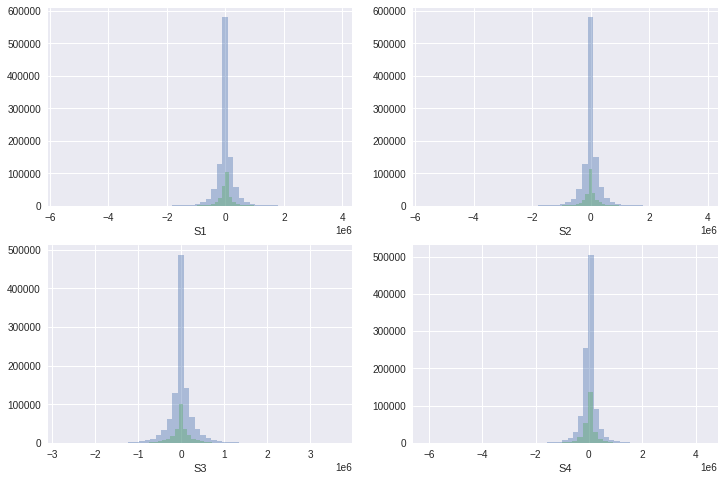

In [ ]:
# Inputs 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
sns.distplot(train_df.S1, kde=False, label='train', ax=ax[0]) 
sns.distplot(test_df.S1, kde=False, label='test', ax=ax[0])

sns.distplot(train_df.S2,kde=False, label='train', ax=ax[1])
sns.distplot(test_df.S2, kde=False, label='test', ax=ax[1])

sns.distplot(train_df.S3,kde=False, label='train', ax=ax[2]) 
sns.distplot(test_df.S3, kde=False, label='test', ax=ax[2])

sns.distplot(train_df.S4, kde=False,label='train', ax=ax[3]) 
sns.distplot(test_df.S4, kde=False, label='test', ax=ax[3])

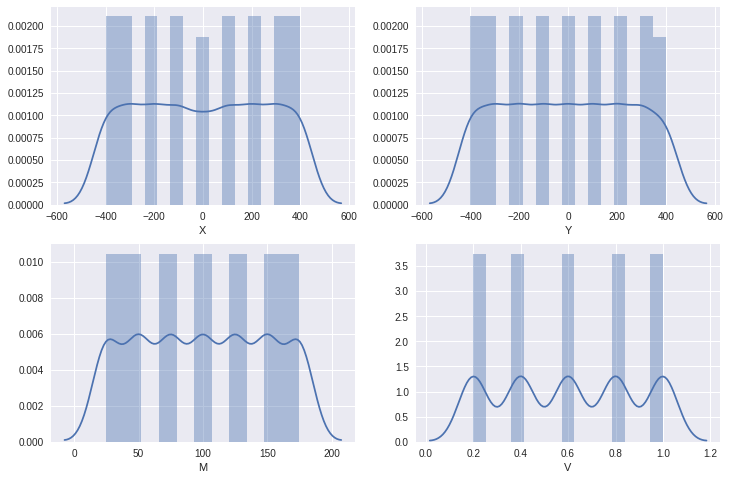

In [ ]:
# Targets
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
sns.distplot(targets.X, label='train X', ax=ax[0]) 
sns.distplot(targets.Y, label='train Y', ax=ax[1]) 
sns.distplot(targets.M, label='train M', ax=ax[2]) 
sns.distplot(targets.V, label='train V', ax=ax[3]) 

In [ ]:
targets.V.value_counts()

In [ ]:
targets.M.value_counts()

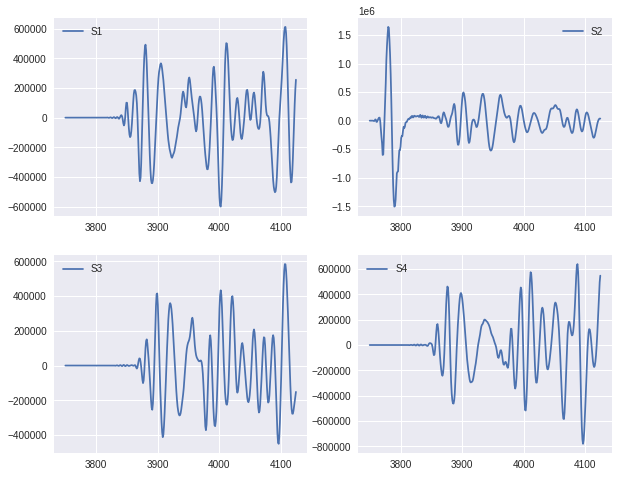

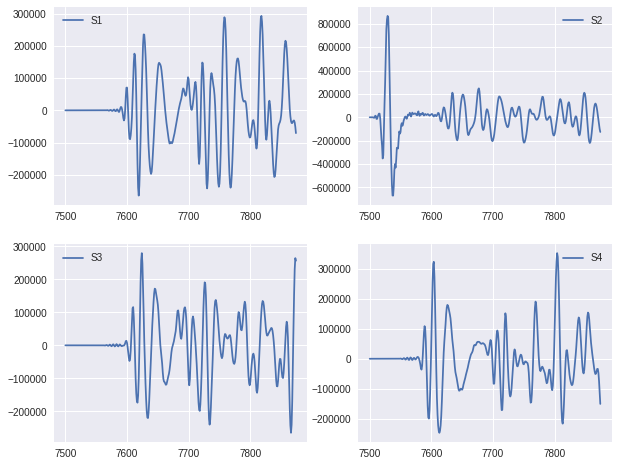

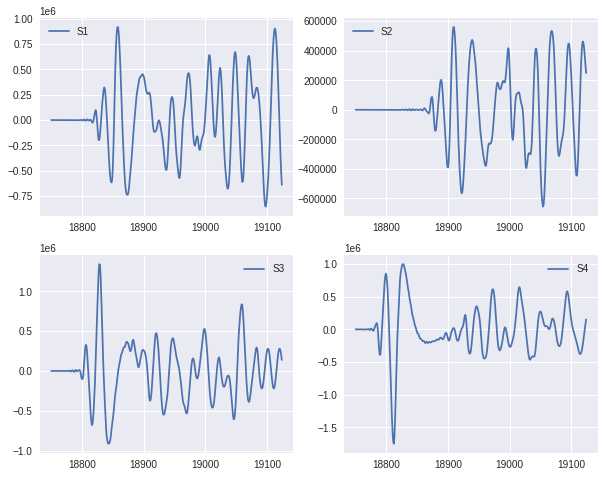

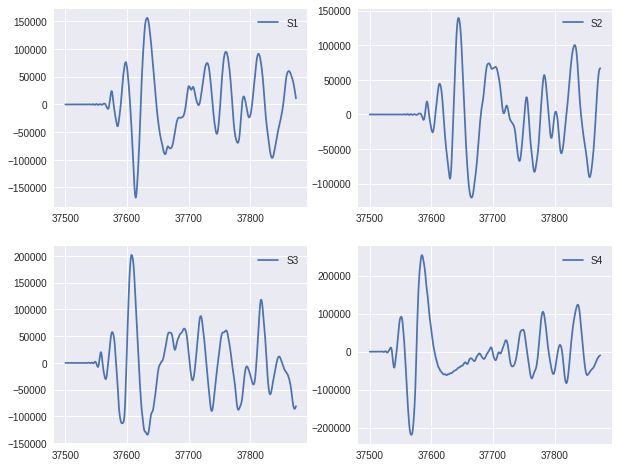

In [ ]:
def plot_sensor_data(idx=10):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    ax = ax.flatten()
    train_df[train_df.id==idx][['S1']].plot(ax=ax[0])
    train_df[train_df.id==idx][['S2']].plot(ax=ax[1])
    train_df[train_df.id==idx][['S3']].plot(ax=ax[2])
    train_df[train_df.id==idx][['S4']].plot(ax=ax[3])
    plt.show()

plot_sensor_data(idx=10)

plot_sensor_data(idx=20)

plot_sensor_data(idx=50)

plot_sensor_data(idx=100)

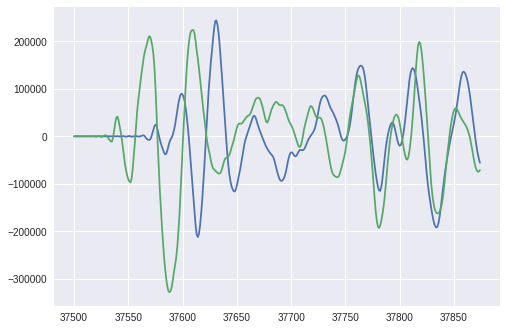

In [ ]:
idx = 100

sig12 = train_df[train_df.id==idx]['S1'] - train_df[train_df.id==idx]['S2']
sig34 = train_df[train_df.id==idx]['S3'] - train_df[train_df.id==idx]['S4']

plt.plot(sig12)
plt.plot(sig34)

In [ ]:
# # plt.plot(ewm2[0,:,0])
# # plt.plot(ewm2[0,:,1])
# plt.plot(ewm2[0,:,2])
# plt.plot(ewm2[0,:,3])
# plt.plot(train_df['S1'].values.reshape(2800, 375, -1)[0, :, ])

#4: Feature Engineering & Initial Modeling

**A. Create lag features**

In [11]:
# create lag features (-1, 375, )
train_df_lag = lag_with_pct_change(train_df, [5, 10, 20],  add_pct_change=False, add_pct_change_lag=False)
test_df_lag = lag_with_pct_change(test_df, [5, 10, 20],  add_pct_change=False, add_pct_change_lag=False)

In [12]:
print('shapes:', train_df_lag.shape, test_df_lag.shape)
train_df_lag.columns.tolist()

shapes: (1050000, 30) (262500, 30)


['id',
 'Time',
 'S1',
 'S2',
 'S3',
 'S4',
 'S1_shift_pos_5',
 'S1_shift_neg_5',
 'S1_shift_pos_10',
 'S1_shift_neg_10',
 'S1_shift_pos_20',
 'S1_shift_neg_20',
 'S2_shift_pos_5',
 'S2_shift_neg_5',
 'S2_shift_pos_10',
 'S2_shift_neg_10',
 'S2_shift_pos_20',
 'S2_shift_neg_20',
 'S3_shift_pos_5',
 'S3_shift_neg_5',
 'S3_shift_pos_10',
 'S3_shift_neg_10',
 'S3_shift_pos_20',
 'S3_shift_neg_20',
 'S4_shift_pos_5',
 'S4_shift_neg_5',
 'S4_shift_pos_10',
 'S4_shift_neg_10',
 'S4_shift_pos_20',
 'S4_shift_neg_20']

In [13]:
print(train_df_lag.isnull().sum().sum(), test_df_lag.isnull().sum().sum())

0 0


**B. Create features from agg statistics** (mean, median, min, max etc)

In [14]:
# add agg stats features (-1, )
train_df2 = preprocess_data(train_df, cols=['S1','S2','S3','S4'])
test_df2 = preprocess_data(test_df, cols=['S1','S2','S3','S4'])

In [15]:
print('shapes:',train_df2.shape, test_df2.shape)
train_df2.columns.tolist()

shapes: (2800, 69) (700, 69)


['Time',
 'S1_mean',
 'S1_max',
 'S1_min',
 'S1_std',
 'S1_median',
 'S1_p10',
 'S1_p25',
 'S1_p75',
 'S1_p90',
 'S1_skew',
 'S1_norm',
 'S1_mean_abs_chg',
 'S1_abs_max',
 'S1_abs_min',
 'S1_range',
 'S1_maxtomin',
 'S1_abs_avg',
 'S2_mean',
 'S2_max',
 'S2_min',
 'S2_std',
 'S2_median',
 'S2_p10',
 'S2_p25',
 'S2_p75',
 'S2_p90',
 'S2_skew',
 'S2_norm',
 'S2_mean_abs_chg',
 'S2_abs_max',
 'S2_abs_min',
 'S2_range',
 'S2_maxtomin',
 'S2_abs_avg',
 'S3_mean',
 'S3_max',
 'S3_min',
 'S3_std',
 'S3_median',
 'S3_p10',
 'S3_p25',
 'S3_p75',
 'S3_p90',
 'S3_skew',
 'S3_norm',
 'S3_mean_abs_chg',
 'S3_abs_max',
 'S3_abs_min',
 'S3_range',
 'S3_maxtomin',
 'S3_abs_avg',
 'S4_mean',
 'S4_max',
 'S4_min',
 'S4_std',
 'S4_median',
 'S4_p10',
 'S4_p25',
 'S4_p75',
 'S4_p90',
 'S4_skew',
 'S4_norm',
 'S4_mean_abs_chg',
 'S4_abs_max',
 'S4_abs_min',
 'S4_range',
 'S4_maxtomin',
 'S4_abs_avg']

In [16]:
print(train_df2.isnull().sum().sum(), test_df2.isnull().sum().sum())

0 0


**C. Create exponential weighted features** (not used in final solution)

In [ ]:
# for col in ['S1', 'S2', 'S3', 'S4']:
#     ewm = calc_ewm(train_df[col])
#     ewm.columns = [col+'_'+n for n in ewm.columns]
#     train_df = pd.concat([train_df, ewm], axis=1)

# del ewm
# gc.collect()

# print(train_df.shape)
# train_df.head()

# for col in ['S1', 'S2', 'S3', 'S4']:
#     ewm = calc_ewm(test_df[col])
#     ewm.columns = [col+'_'+n for n in ewm.columns]
#     test_df = pd.concat([test_df, ewm], axis=1)

# print(test_df.shape)
# test_df.head()

**D. Create FFT based features** (not used in final solution)

In [ ]:
# Train set FFT features (not included in final solution)

# s_fft = make_fft_features(train_df)
# train_df_fft = pd.DataFrame()
# train_df_fft['S1_fft']= s_fft[:,:,0].reshape(-1)
# train_df_fft['S2_fft']= s_fft[:,:,1].reshape(-1)
# train_df_fft['S3_fft']= s_fft[:,:,2].reshape(-1)
# train_df_fft['S4_fft']= s_fft[:,:,3].reshape(-1)

# print(train_df_fft.head(3))

# del s_fft
# gc.collect()

# # Test set FFT features 
# s_fft = make_fft_features(test_df)
# test_df_fft = pd.DataFrame()
# test_df_fft['S1_fft']= s_fft[:,:,0].reshape(-1)
# test_df_fft['S2_fft']= s_fft[:,:,1].reshape(-1)
# test_df_fft['S3_fft']= s_fft[:,:,2].reshape(-1)
# test_df_fft['S4_fft']= s_fft[:,:,3].reshape(-1)

# print(test_df_fft.head(3))

# del s_fft
# gc.collect()

**Features correlations (agg stats)**

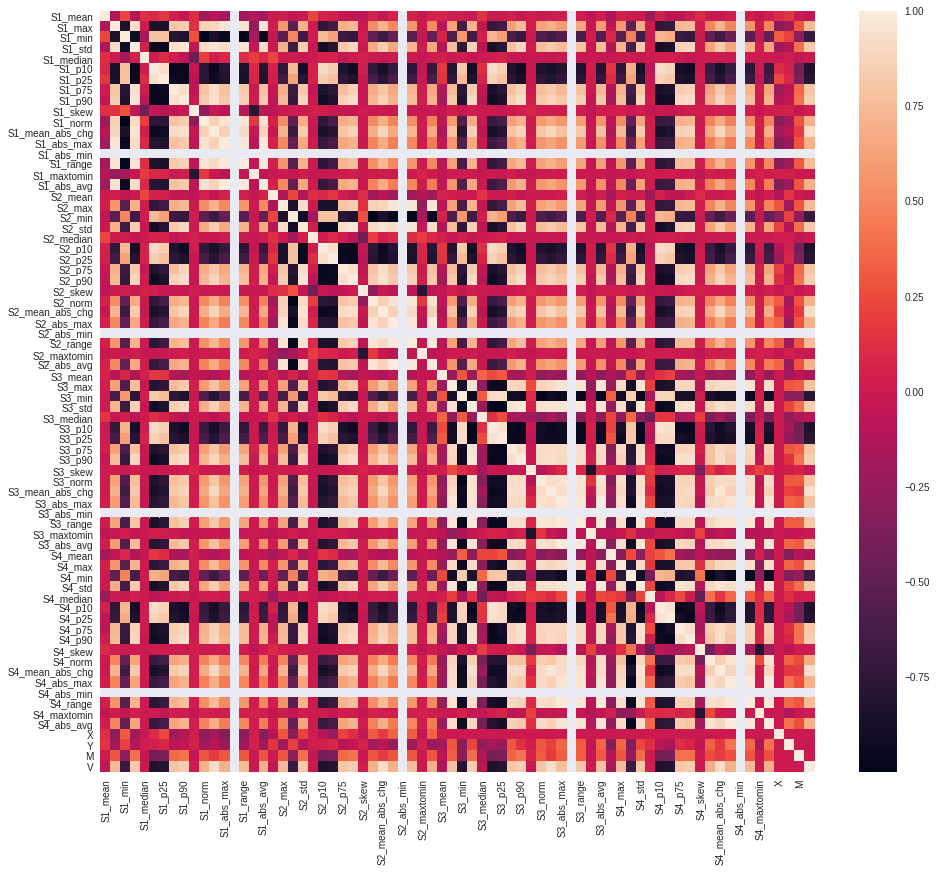

In [ ]:
plt.figure(figsize=(16,14))
sns.heatmap(pd.concat([train_df2.iloc[:, 1:], targets.drop(['id'], axis=1)], axis=1).corr());

**Top features for X,Y**

**Top features for M**

**Top features for V**

**Prepare data for training**

In [17]:
feats = [col for col in train_df_lag.columns if col not in 'id']
n_feats = len(feats)  

# feats= ['Time', 'S1', 'S2', 'S3', 'S4']
# feats_fft = ['S1_fft', 'S2_fft', 'S3_fft', 'S4_fft'] 
# print(feats, len(feats))

print('all features #', len(feats), feats)

all features # 29 ['Time', 'S1', 'S2', 'S3', 'S4', 'S1_shift_pos_5', 'S1_shift_neg_5', 'S1_shift_pos_10', 'S1_shift_neg_10', 'S1_shift_pos_20', 'S1_shift_neg_20', 'S2_shift_pos_5', 'S2_shift_neg_5', 'S2_shift_pos_10', 'S2_shift_neg_10', 'S2_shift_pos_20', 'S2_shift_neg_20', 'S3_shift_pos_5', 'S3_shift_neg_5', 'S3_shift_pos_10', 'S3_shift_neg_10', 'S3_shift_pos_20', 'S3_shift_neg_20', 'S4_shift_pos_5', 'S4_shift_neg_5', 'S4_shift_pos_10', 'S4_shift_neg_10', 'S4_shift_pos_20', 'S4_shift_neg_20']


In [18]:
# Training data for model1
SCALE = True   # False

if SCALE:     
    sc_inp = StandardScaler()
    X = sc_inp.fit_transform(train_df_lag[feats].values)
    X_test = sc_inp.transform(test_df_lag[feats].values)
else: 
    X = train_df_lag[feats].values
    X_test = test_df_lag[feats].values

# reshape arrays
X = X.reshape(int(len(train_df)/375), 375, n_feats, 1)
X_test = X_test.reshape(int(len(test_df)/375), 375, n_feats, 1)
y = targets[['X', 'Y', 'M', 'V']]

X.shape, X_test.shape, y.shape

((2800, 375, 29, 1), (700, 375, 29, 1), (2800, 4))

In [19]:
# Training data for model2
train_x2 = train_df[['Time','S1','S2','S3','S4']].values.reshape((-1, 1, 375, 5))
test_x2 = test_df[['Time','S1','S2','S3','S4']].values.reshape((-1, 1, 375, 5))

# concatenate normalized data
train_norm = normalize(train_x2)
test_norm = normalize(test_x2)

X2 = np.concatenate((train_x2, train_norm), axis=1)
X2_test = np.concatenate((test_x2, test_norm), axis=1)
X2_test = torch.FloatTensor(X2_test)

del train_x2, test_x2, train_norm, test_norm
gc.collect()

X2.shape, X2_test.shape

((2800, 2, 375, 5), torch.Size([700, 2, 375, 5]))

In [20]:
# Training data for model3

SCALE = True

if SCALE:     
    sc_inp2 = StandardScaler()
    X3 = sc_inp2.fit_transform(train_df2.iloc[:, 1:])
    X3_test = sc_inp2.transform(test_df2.iloc[:, 1:])
else: 
    X3 = train_df2.iloc[:, 1:]
    X3_test = test_df2.iloc[:, 1:]

X3.shape, X3_test.shape

((2800, 68), (700, 68))

In [21]:
del train_df, test_df, targets
del train_df2, test_df2
del train_df_lag, test_df_lag
gc.collect()

218

### Model 1 [Pytorch]

In [22]:
# Model 1 [Pytorch]

class build_cnn_2(nn.Module):
    def __init__(self, n_feature, out_len, no_channels):
        super(build_cnn_2, self).__init__()
        self.conv_kernel = (5, 1)      # (4,1)
        self.pool_kernel = (2, 1)
        
        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=no_channels, out_channels=16, kernel_size=self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = self.pool_kernel),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = self.pool_kernel),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = self.pool_kernel),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = self.pool_kernel),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = self.pool_kernel),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size = self.conv_kernel, stride=1),
            nn.ELU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size = self.pool_kernel)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*1*n_feature, 256),
            nn.ELU(),     
            # nn.ReLU(),
            nn.Linear(256, 128),
            nn.ELU(),   
            # nn.ReLU(),
            nn.Linear(128, 64),
            nn.ELU(),
            # nn.ReLU(),
            nn.Linear(64, out_len)
        )
        
    def forward(self, x):
        x = self.fe(x)
        return self.fc(x.view(x.size(0), -1))




### Model 2 [TF Keras]

In [23]:
# TF Keras Model 1

def build_cnn_1(gap=False):

    activ = 'elu'                  
    padding = 'valid'   #'same'                  
    nf = 32
    fs = (5,1)                     
    batch_norm = (True, False)
    dp = 0.2

    inp = Input(shape=X.shape[1:])

    # layer-1
    x = Conv2D(nf, fs, padding=padding, activation=activ, kernel_initializer='he_uniform')(inp)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)    # LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    # layer-2
    x =Conv2D(nf*2, fs, padding=padding, activation=activ, kernel_initializer='he_uniform')(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)   # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-3
    x = Conv2D(nf*4, fs, padding=padding, activation=activ, kernel_initializer='he_uniform')(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)  # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)


    # layer-4
    x = Conv2D(nf*8, fs, padding=padding, activation=activ, kernel_initializer='he_uniform')(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)  # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-5
    x = Conv2D(nf*16, fs, padding=padding, activation=activ, kernel_initializer='he_uniform')(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)  # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-6
    x = Conv2D(nf*32, fs, padding=padding, activation=activ, )(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    # x = ELU()(x)  # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    if gap:
        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)
    
    # FC
    x = Dense(256, activation=activ, kernel_initializer='uniform')(x)
    if batch_norm[1]:
        x = BatchNormalization()(x)
    # x = ELU()(x)                 
    x = Dropout(dp)(x)

    x = Dense(128, activation=activ, kernel_initializer='uniform')(x)
    if batch_norm[1]:
        x = BatchNormalization()(x)
    # x = ELU()(x) 
    x = Dropout(dp)(x)
    
    x = Dense(64, activation=activ, kernel_initializer='uniform')(x)
    if batch_norm[1]:
        x = BatchNormalization()(x)
    # x = ELU()(x) 
    x = Dropout(dp)(x)

    out = Dense(4, activation='linear')(x)
    model = tf.keras.models.Model(inputs=[inp], outputs=[out])
    return model


In [25]:
build_cnn_1(gap=False).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 375, 29, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 371, 29, 32)       192       
_________________________________________________________________
batch_normalization (BatchNo (None, 371, 29, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 185, 29, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 181, 29, 64)       10304     
_________________________________________________________________
batch_normalization_1 (Batch (None, 181, 29, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 29, 64)        0     

### Model 3 [TF Keras]

In [24]:
# TF Keras Model-3

def build_cnn_3(gap=False):

    activ = 'elu'                   # 'relu'
    padding = 'valid'               # 'same'
    nf = 32
    fs = (5,1)                      # (5,1) (3,1)
    batch_norm = (True, True)
    dp = 0.2
    k_init = 'he_uniform'    # tf.keras.initializers.glorot_normal()

    # input-1
    inp = Input(shape=X.shape[1:])

    # layer-1
    x = Conv2D(nf, fs, padding=padding, activation=None, kernel_initializer=k_init)(inp)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)    
    # LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    
    # layer-2
    x = Conv2D(nf*2, fs, padding=padding, activation=None, kernel_initializer=k_init)(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)   
    # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-3
    x = Conv2D(nf*4, fs, padding=padding, activation=None, kernel_initializer=k_init)(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)  
    # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-4
    x = Conv2D(nf*8, fs, padding=padding, activation=None, kernel_initializer=k_init)(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)  
    # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-5
    x = Conv2D(nf*16, fs, padding=padding, activation=None, kernel_initializer=k_init)(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)  
    # x = LeakyReLU(alpha=0.05)(x)
    x = MaxPooling2D(pool_size=(2, 1))(x)

    # layer-6
    x = Conv2D(nf*32, fs, padding=padding, activation=None, kernel_initializer=k_init)(x)
    if batch_norm[0]:
        x = BatchNormalization()(x)
    x = ELU()(x)  
    # x = LeakyReLU(alpha=0.05)(x)
    x1 = MaxPooling2D(pool_size=(2, 1))(x)
    x1 = Flatten()(x1)

    # Input-2 
    inp2 = Input(shape=X3.shape[1])
    x2 = Dense(512, activation='elu')(inp2)
    x2 = Dropout(dp)(x2)
    x2 = Dense(256, activation='elu')(x2)
    x2 = Dropout(dp)(x2)

    # merge 
    comb = concatenate([x1,x2])

    if gap:
        x3 = GlobalAveragePooling2D()(comb)
    else:
        x3 = Flatten()(comb)
    
    # FC
    x3 = Dense(1024, activation='linear')(x3)
    if batch_norm[1]:
        x3 = BatchNormalization()(x3)
    x3 = ELU()(x3)                       
    x3 = Dropout(dp)(x3)

    x3 = Dense(512, activation='linear')(x3)
    if batch_norm[1]:
        x3 = BatchNormalization()(x3)
    x3 = ELU()(x3)
    x3 = Dropout(dp)(x3)
    
    x3 = Dense(128, activation='linear')(x3)
    if batch_norm[1]:
        x3 = BatchNormalization()(x3)
    x3 = ELU()(x3)
    x3 = Dropout(dp)(x3)

    out = Dense(4, activation='linear')(x3)
    model = tf.keras.models.Model(inputs=[inp, inp2], outputs=[out])
    return model

In [ ]:
build_cnn_3(gap=False).summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 375, 29, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 371, 29, 32)  192         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 371, 29, 32)  128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
elu_3 (ELU)                     (None, 371, 29, 32)  0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

#5: Model Training & Evaluation

Master Params

In [26]:
DEBUG = False # True

nfold = 5         # use 10 for final solution
base_lr = 0.001   # 0.01
initialize = True
print_summary = True

BATCH_SIZE = 128   # 32   # 256
EPOCHS = 300

if DEBUG:
    EPOCHS = 2
    nfold = 2

### Model-1-XY [Pytorch]

In [ ]:
# train XY
train_target = 'XY'
loss_xy = kfold_train('XY', X2, y)

print('-'*10)
print('> OOF loss XY:', np.mean(loss_xy))
print('-'*10)

add_feature = y[['X','Y']].values.reshape((2800, 1, 1, 2))
add_feature = np.repeat(add_feature, 375, axis=2)
add_feature = np.repeat(add_feature, 2, axis=1)
X2_v = np.concatenate([X2, add_feature], axis=-1)

# X2_v.shape

> XY train...
----------
fold 1/5
----------
[1] train loss: 1.623090,  val loss drop: 10000000.0000 to: 0.3326
[2] train loss: 0.095684,  val loss drop: 0.3326 to: 0.1576
[3] train loss: 0.021609,  val loss drop: 0.1576 to: 0.0109
[4] train loss: 0.007383,  val loss drop: 0.0109 to: 0.0074
[6] train loss: 0.006679,  val loss drop: 0.0074 to: 0.0049
[8] train loss: 0.002371,  val loss drop: 0.0049 to: 0.0029
[10] train loss: 0.001955,  val loss drop: 0.0029 to: 0.0022
[13] train loss: 0.002089,  val loss drop: 0.0022 to: 0.0011
[14] train loss: 0.001292,  val loss drop: 0.0011 to: 0.0010
[23] train loss: 0.001567,  val loss drop: 0.0010 to: 0.0008
[38] train loss: 0.000959,  val loss drop: 0.0008 to: 0.0007
[54] train loss: 0.001291,  val loss drop: 0.0007 to: 0.0006
[65] train loss: 0.001094,  val loss drop: 0.0006 to: 0.0006
[69] train loss: 0.000461,  val loss drop: 0.0006 to: 0.0005
[74] train loss: 0.000570,  val loss drop: 0.0005 to: 0.0004
Epoch    90: reducing learning rate of 

### Model-1-V [Pytorch]

In [ ]:
# train V using XY
train_target = 'V'
loss_v = kfold_train('V', X2_v, y)

print('-'*10)
print('> OOF loss V:', np.mean(loss_v))
print('-'*10)

add_feature = y[['V']].values.reshape((2800, 1, 1, 1))
add_feature = np.repeat(add_feature, 375, axis=2)
add_feature = np.repeat(add_feature, 2, axis=1)
X2_m = np.concatenate((X2_v, add_feature), axis=-1)

X2_m.shape

> V train...
----------
fold 1/5
----------
[1] train loss: 16.829895,  val loss drop: 10000000.0000 to: 0.8249
[2] train loss: 0.217815,  val loss drop: 0.8249 to: 0.1061
[3] train loss: 0.044246,  val loss drop: 0.1061 to: 0.0288
[4] train loss: 0.019215,  val loss drop: 0.0288 to: 0.0191
[5] train loss: 0.011459,  val loss drop: 0.0191 to: 0.0163
[7] train loss: 0.009995,  val loss drop: 0.0163 to: 0.0114
[8] train loss: 0.011196,  val loss drop: 0.0114 to: 0.0095
[9] train loss: 0.007255,  val loss drop: 0.0095 to: 0.0091
[10] train loss: 0.010380,  val loss drop: 0.0091 to: 0.0085
[11] train loss: 0.005455,  val loss drop: 0.0085 to: 0.0064
[19] train loss: 0.003667,  val loss drop: 0.0064 to: 0.0046
[20] train loss: 0.003010,  val loss drop: 0.0046 to: 0.0042
[30] train loss: 0.007968,  val loss drop: 0.0042 to: 0.0031
[31] train loss: 0.003720,  val loss drop: 0.0031 to: 0.0027
[41] train loss: 0.004133,  val loss drop: 0.0027 to: 0.0025
[42] train loss: 0.004221,  val loss drop

(2800, 2, 375, 8)

### Model-1-M [Pytorch]

In [ ]:
# train M 
train_target = 'M'
loss_m = kfold_train('M', X2_m, y)

print('-'*10)
print('> OOF loss M:', np.mean(loss_m))
print('-'*10)

> M train...
----------
fold 1/5
----------
[1] train loss: 17.761390,  val loss drop: 10000000.0000 to: 16.4242
[2] train loss: 1.228480,  val loss drop: 16.4242 to: 13.1234
[3] train loss: 0.826616,  val loss drop: 13.1234 to: 0.2921
[10] train loss: 0.467483,  val loss drop: 0.2921 to: 0.1276
[17] train loss: 0.225082,  val loss drop: 0.1276 to: 0.0761
[20] train loss: 0.386557,  val loss drop: 0.0761 to: 0.0747
[26] train loss: 0.367959,  val loss drop: 0.0747 to: 0.0740
[31] train loss: 0.192129,  val loss drop: 0.0740 to: 0.0366
[45] train loss: 0.216724,  val loss drop: 0.0366 to: 0.0251
Epoch    61: reducing learning rate of group 0 to 7.0000e-04.
[68] train loss: 0.212289,  val loss drop: 0.0251 to: 0.0187
Epoch    84: reducing learning rate of group 0 to 4.9000e-04.
[85] train loss: 0.126084,  val loss drop: 0.0187 to: 0.0138
[93] train loss: 0.111156,  val loss drop: 0.0138 to: 0.0072
Epoch   109: reducing learning rate of group 0 to 3.4300e-04.
Epoch   125: reducing learnin

### Model-2-XY [TF-Keras]

88/88 [==============================] - 25s 284ms/step - loss: 0.5663


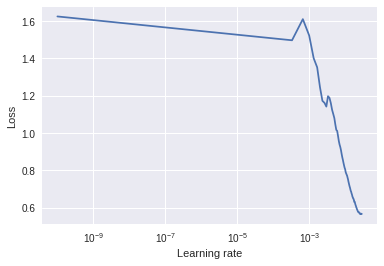

18010

In [ ]:
# LRFinder

train_target = 0

# BATCH_SIZE = 256
# EPOCHS = 300
# LR = 0.001

global weight2
if train_target == 1:  
    weight2 = np.array([0,0,1,0])  # only for M
else: 
    weight2 = np.array([0,0,0,1])    # only for V
    
## compile model
model0_ = build_cnn_1(gap=False)

optimizer = tf.keras.optimizers.Adam()
model0_.compile(loss=loss_E1, optimizer=optimizer) # 'adam'
lr_finder = LRFinder(min_lr=1e-10, max_lr=0.01, steps_per_epoch=10, epochs=3)

model0_.fit(X, y, callbacks=[lr_finder])

plt.figure()
lr_finder.plot_loss()

# # plt.figure()
# # lr_finder.plot_lr()

del model0_ 
gc.collect()

In [28]:
train_target = 0

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])    # only for M
else: 
    weight2 = np.array([0,0,0,1])    # only for V

MODEL_NAME = 'model_1_XY.h5'  
model1_x = build_cnn_1(gap=False)
LR = 0.001
optimizer = tf.keras.optimizers.Adam(LR)
optimizer = tfa.optimizers.SWA(optimizer)  #  RectifiedAdam()
    
model1_x.compile(loss=loss_E1, optimizer=optimizer)

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
# select LR schedule Callback
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7, min_lr=1e-8)
# lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.5, step_size=5)
lr_schedule = CyclicLR(base_lr=0.001, max_lr=0.006, mode='exp_range', gamma=0.99994)  #  step_size=5000.,
# lr_schedule = WarmUpCosineDecayScheduler(learning_rate_base=LR)

callbacks=[es,  mc, lr_schedule]             

print('> Train Model-1 for XY')  
print()

hist1_x = model1_x.fit(X, y,                   
                 validation_split=0.25,    
                 batch_size=100,   # BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist1_x = pd.DataFrame(hist1_x.history)

> Train Model-1 for XY

Epoch 1/300
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
21/21 [==============================] - ETA: 0s - loss: 0.6170
Epoch 00001: val_loss improved from inf to 9.23585, saving model to /content/drive/My Drive/ML Projects/DACON/Kaeri/models/model_1_XY.h5
21/21 [==============================] - 28s 1s/step - loss: 0.6170 - val_loss: 9.2358
Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.0883
Epoch 00002: val_loss improved from 9.23585 to 5.99584, saving model to /content/drive/My Drive/ML Projects/DACON/Kaeri/models/model_1_XY.h5
21/21 [==============================] - 12s 568ms/step - loss: 0.0883 - val_loss: 5.9958
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.0713
Epoch 00003: val_loss improved from 5.99584 to 2.53209, saving model to /content/drive/My Drive/ML Projects/DACON/Kaeri/models/model_1_XY.h5
21/21 [==============================] - 12s 569ms/step - loss: 0.0713 

(0.0, 1.0)

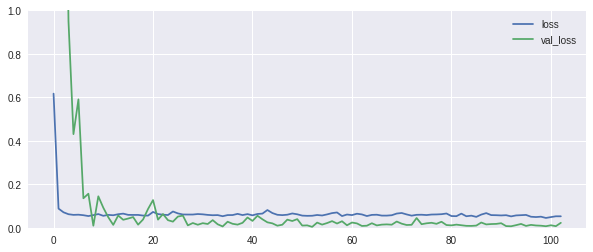

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
hist1_x[['loss', 'val_loss']].plot(ax=ax)
ax.set_ylim([0.0, 1.0])

In [30]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist1_x[['val_loss']].min(), 
      np.argmin(hist1_x[['val_loss']])))

Min valid loss [0.00434] at epoch [52]


In [ ]:
# model1_x_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_XY.h5')

### Model-2-M [TF_Keras]

In [ ]:
train_target = 1

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])   # only for M
else: 
    weight2 = np.array([0,0,0,1])    # only for V

MODEL_NAME = 'model_1_M.h5'    

model1_m = build_cnn_1(gap=False)

LR = 0.01
optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(optimizer)
    
model1_m.compile(loss=loss_E2, optimizer=optimizer)  

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7)
# lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.5, step_size=5)
lr_schedule = CyclicLR(base_lr=0.01, max_lr=0.08, step_size=25., mode='exp_range', gamma=0.99994)   # 
# lr_schedule = WarmUpCosineDecayScheduler()

callbacks=[es, mc, lr_schedule]             

print('> Train Model-1 for M')
print()

hist1_m = model1_m.fit(X, y,                
                 validation_split=0.2,     
                 batch_size=100,  #  BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist1_m_df = pd.DataFrame(hist1_m.history)

In [ ]:
# f, ax = plt.subplots()
hist1_m_df[['loss', 'val_loss']].plot(figsize=(10,4))
ax.set_ylim([0,0.1])

In [ ]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist1_m_df[['val_loss']].min(), 
      np.argmin(hist1_m_df[['val_loss']])))

In [ ]:
# model1_m_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_M.h5')

### Model-2-V [TF-Keras] 

In [ ]:
# ## LR Finder 

# model2_ = build_cnn_model(gap=False)
# optimizer = tf.keras.optimizers.Adam(0.1)
# optimizer = tfa.optimizers.SWA(optimizer)
# model2_.compile(loss=loss_E2, optimizer=optimizer) 
# lr_finder = LRFinder(min_lr=1e-5, max_lr=0.3, steps_per_epoch=10, epochs=3)
# model2_.fit(X, y, callbacks=[lr_finder])

# plt.figure()
# lr_finder.plot_loss()

# del model2_
# gc.collect()

In [ ]:
train_target = 2

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])      # only for M
else: 
    weight2 = np.array([0,0,0,1])      # only for V

MODEL_NAME = 'model_1_V.h5'  
model1_v = build_cnn_1(gap=False)

LR = 0.1
optimizer = tf.keras.optimizers.Adam()
# optimizer = tfa.optimizers.SWA(optimizer)
model1_v.compile(loss=loss_E2, optimizer=optimizer)   

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7)
# lr_schedule = step_decay_schedule(initial_lr=1e-4, decay_factor=0.5, step_size=15)
lr_schedule = CyclicLR(base_lr=0.01,  mode='exp_range', gamma=0.9999)  # max_lr=0.,
# lr_schedule = WarmUpCosineDecayScheduler(LR)

callbacks=[es, mc, lr_schedule]             


print('> Train Model-1 for V')
print()

hist1_v = model1_v.fit(X, y,               
                 validation_split=0.2,     
                 batch_size=100,   # BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist1_v_df = pd.DataFrame(hist1_v.history)

In [ ]:
plt.figure()
hist1_v_df[['loss', 'val_loss']].plot()
plt.ylim(0, 1.0)

In [ ]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist1_v_df[['val_loss']].min(), 
      np.argmin(hist1_v_df[['val_loss']])) )

In [ ]:
# model1_v_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_V.h5')

In [ ]:
del model1_m, model1_x, model1_v, 
del hist1_m, hist1_m_df, hist1_v, hist1_v_df, hist1_x
gc.collect()

In [ ]:
gc.collect()

In [ ]:
# %whos

### Model-3-XY [TF-Keras]

In [ ]:
train_target = 0

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])    # only for M
else: 
    weight2 = np.array([0,0,0,1])    # only for V


MODEL_NAME = 'model_3_XY.h5'   
model3_x = build_cnn_3(gap=False)

LR = 0.01
optimizer = tf.keras.optimizers.Adam(LR)
optimizer = tfa.optimizers.SWA(optimizer)  #  RectifiedAdam()
model3_x.compile(loss=loss_E1, optimizer=optimizer, metrics=[r2_keras])

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7)
lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.7, step_size=30)
# lr_schedule = CyclicLR(base_lr=0.001, max_lr=0.06, step_size=5000., mode='exp_range', gamma=0.99994)  # 
# lr_schedule = WarmUpCosineDecayScheduler(learning_rate_base=LR)

callbacks=[es,  mc, lr_schedule]             

print('> Train Model-3 for XY')  
print()

hist3_x = model3_x.fit([X, X3], y,                   
                 validation_split=0.2,    
                 batch_size=100,   #BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist3_x_df = pd.DataFrame(hist3_x.history)


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
hist3_x_df[['loss', 'val_loss']].plot(ax=ax[0])
hist3_x_df[['r2_keras', 'val_r2_keras']].plot(ax=ax[1])
ax[1].set_ylim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.5])

In [ ]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist3_x_df[['val_loss']].min(), 
      np.argmin(hist3_x_df[['val_loss']])))

In [ ]:
# model3_x_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_XY.h5')

###Model-3-M [TF-Keras]

In [ ]:
train_target = 1

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])   # only for M
else: 
    weight2 = np.array([0,0,0,1])    # only for V

MODEL_NAME = 'model_3_M.h5'  
model3_m = build_cnn_3(gap=False)

LR = 0.01
optimizer = tf.keras.optimizers.Adam()
optimizer = tfa.optimizers.SWA(optimizer)
model3_m.compile(loss=loss_E2, optimizer=optimizer)   

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7)
lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.7, step_size=30)
# lr_schedule = CyclicLR(base_lr=0.001, max_lr=0.08, step_size=25., mode='exp_range', gamma=0.99994)   # 
# lr_schedule = WarmUpCosineDecayScheduler()

callbacks=[es, mc, lr_schedule]             

print('> Train Model-3 for M')
print()

hist3_m = model3_m.fit([X, X3], y,                
                 validation_split=0.2,     
                 batch_size=100,   #BATCH_SIZE,
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist3_m_df = pd.DataFrame(hist3_m.history)


In [ ]:
f, ax = plt.subplots(1,2, figsize=(10,4))
hist3_m_df[['loss', 'val_loss']].plot(ax=ax[0])
hist3_m_df['lr'].plot(ax=ax[1])
ax[0].set_ylim([0,0.1])

In [ ]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist3_m_df[['val_loss']].min(), 
      np.argmin(hist3_m_df[['val_loss']])))

In [ ]:
# model3_m_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_M.h5')

### Model-3-V [TF-Keras]

In [ ]:
train_target = 2

global weight2
if train_target == 1: 
    weight2 = np.array([0,0,1,0])      # only for M
else: 
    weight2 = np.array([0,0,0,1])     # only for V

MODEL_NAME = 'model_3_V.h5' 
model3_v = build_cnn_3(gap=False)

LR = 0.01
optimizer = tf.keras.optimizers.Adam(LR)
optimizer = tfa.optimizers.SWA(optimizer)     
model3_v.compile(loss=loss_E2, optimizer=optimizer)   

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH+MODEL_NAME, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.7)
lr_schedule = step_decay_schedule(initial_lr=1e-2, decay_factor=0.1, step_size=30)
# lr_schedule = CyclicLR(base_lr=0.01, max_lr=0.08, step_size=2000., mode='exp_range', gamma=0.99994)  # 
# lr_schedule = WarmUpCosineDecayScheduler()

callbacks=[es, mc, lr_schedule]             

print('> Train Model-3 for V')
print()

hist3_v = model3_v.fit([X, X3], y,               
                 validation_split=0.2,     
                 batch_size=100,   #BATCH_SIZE,   
                 epochs=EPOCHS,
                 verbose=1,
                 shuffle=True,
                 callbacks=callbacks)

hist3_v_df = pd.DataFrame(hist3_v.history)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(10,4))
hist3_v_df[['loss', 'val_loss']].plot(ax=ax[0])
hist3_v_df['lr'].plot(ax=ax[1])
ax[0].set_ylim([0,0.1])

In [ ]:
print('Min valid loss [%.5f] at epoch [%.0f]' % (hist3_v_df[['val_loss']].min(), 
      np.argmin(hist3_v_df[['val_loss']])))

In [ ]:
# model3_v_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_V.h5')

In [ ]:
del model3_x, model3_m, model3_v
del hist3_m, hist3_m_df, hist3_x, hist3_x_df, hist3_v, hist3_v_df
gc.collect()

In [ ]:
gc.collect()

In [ ]:
!nvidia-smi

# Predict Test set

### Inference Model-1 [Pytorch]

In [ ]:
subm1 = subm.copy()
subm1.head()

In [ ]:
# predict XY
target = 'XY'
n_features = X2_test.size()[-1]

# define model
model = build_cnn_2(n_features, len(target), X2.shape[1])

result = predict_kfold(model, nfold, MODEL_PATH, target, X2_test)
subm1[list(target)] = result

In [ ]:
n_samples = X2_test.shape[0]
add_feature_t = result.reshape((n_samples, 1, 1, len(target)))
add_feature_t = np.repeat(add_feature_t, 375, axis=2)
add_feature_t = np.repeat(add_feature_t, 2, axis=1)
X2_test_add = torch.cat([X2_test, torch.FloatTensor(add_feature_t)], dim = -1)

In [ ]:
# predict V
target = 'V'
n_features = X2_test_add.size()[-1]

# define model
model = build_cnn_2(n_features, len(target), X2.shape[1])

result = predict_kfold(model, nfold, MODEL_PATH, target, X2_test_add)
subm1[list(target)] = result

In [ ]:
n_samples = X2_test_add.shape[0]
add_feature_t = result.reshape((n_samples, 1, 1, len(target)))
add_feature_t = np.repeat(add_feature_t, 375, axis=2)
add_feature_t = np.repeat(add_feature_t, 2, axis=1)
X2_test_add = torch.cat([X2_test_add, torch.FloatTensor(add_feature_t)], dim=-1)

In [ ]:
# predict M
target = 'M'
n_features = X2_test_add.size()[-1]

# define model
model = build_cnn_2(n_features, len(target), X2.shape[1])

result = predict_kfold(model, nfold, MODEL_PATH, target, X2_test_add)
subm1[list(target)] = result

In [ ]:
subm1.to_csv(out_path+'solution_1.csv', index=False, float_format='%.4f')
subm1.head()

### Inference Model-2 [TF_Keras]

In [ ]:
model1_x_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_XY.h5', custom_objects={'loss_E1': loss_E1})
model1_m_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_M.h5',  custom_objects={'loss_E2': loss_E2})
model1_v_cp = tf.keras.models.load_model(MODEL_PATH+'model_1_V.h5',  custom_objects={'loss_E2': loss_E2})

In [ ]:
subm2 = subm.copy()
subm2.head()

In [ ]:
test_preds1_x = model1_x_cp.predict(X_test)   # Target XY
test_preds1_m = model1_m_cp.predict(X_test)   # Target M
test_preds1_v = model1_v_cp.predict(X_test)   # Target V

subm2.iloc[:,1] = test_preds1_x[:,0]   #.clip(-400, 400)
subm2.iloc[:,2] = test_preds1_x[:,1]   #.clip(-400, 400)
subm2.iloc[:,3] = test_preds1_m[:,2]
subm2.iloc[:,4] = test_preds1_v[:,3]

subm2.to_csv(out_path+'solution_2.csv', index=False, float_format='%.4f')
subm2.head()

del model1_x_cp, model1_m_cp, model1_v_cp
del test_preds1_x, test_preds1_m, test_preds1_v
gc.collect()

### Inference Model-3 [TF-Keras]

In [ ]:
model3_x_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_XY.h5', custom_objects={'loss_E1': loss_E1, 'r2_keras':r2_keras})
model3_m_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_M.h5',  custom_objects={'loss_E2': loss_E2})
model3_v_cp = tf.keras.models.load_model(MODEL_PATH+'model_3_V.h5',  custom_objects={'loss_E2': loss_E2})

In [ ]:
subm3 = subm.copy()
subm3.head()

In [ ]:
test_preds3_x = model3_x_cp.predict([X_test, X3_test])  # Target XY
test_preds3_m = model3_m_cp.predict([X_test, X3_test])  # Target M
test_preds3_v = model3_v_cp.predict([X_test, X3_test])  # Target V

subm3.iloc[:,1] = test_preds3_x[:,0]   #.clip(-400, 400)
subm3.iloc[:,2] = test_preds3_x[:,1]   #.clip(-400, 400)
subm3.iloc[:,3] = test_preds3_m[:,2]
subm3.iloc[:,4] = test_preds3_v[:,3]

subm3.to_csv(out_path+'solution_3.csv', index=False, float_format='%.4f')
subm3.head()

del model3_x_cp, model3_m_cp, model3_v_cp
del test_preds3_x, test_preds3_m, test_preds3_v
gc.collect()

In [ ]:
# train_preds1_x = model1_x_cp.predict(X)
# train_preds1_m = model1_m_cp.predict(X)
# train_preds1_v = model1_v_cp.predict(X)

# train_preds_1 = pd.concat([
#                            pd.Series(train_preds1_x[:,0]), 
#                            pd.Series(train_preds1_x[:,1]),
#                            pd.Series(train_preds1_m[:,2]),
#                            pd.Series(train_preds1_v[:,3])],axis=1)

# print('KAERI metric:', np.round(kaeri_metric(y, train_preds_1),7))

# del train_preds1_x, train_preds1_m, train_preds1_v, 
# del train_preds_1
# gc.collect()

# Ensemble

In [ ]:
submission = subm.copy()
submission.head()

In [ ]:
solutions = [subm1, 
             subm2, 
             subm3]

predictions = np.zeros((700, 4))
for df in solutions:
    predictions += df[['X','Y','M','V']].values * 10

predictions = predictions / (10*len(solutions))
submission[['X','Y','M','V']] = predictions
submission.to_csv(out_path+'final_submission_IME.csv', index=False, float_format='%.4f')
submission.head()

#6: Conclusions and Discussion